## Preprocess and Train Model

### Install Required Packages

In [27]:
%pip install torchvision==0.22.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 300.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.2/905.2 MB 418.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Install torchmetrics for image augmentation
%pip install albumentations

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.8/38.9 MB 4.7 MB/s eta 0:00:09
   - -------------------------------------- 1.0/38.9 MB 4.9 MB/s eta 0:00:08
   -- ------------------------------------- 2.1/38.9 MB 3.6 MB/s eta 0:00:11
   --- ------------------------------------ 3.4/38.9 MB 4.3 MB/s eta 0:00:09
   ------ --------------------------------- 6.0/38.9 MB 6.1 MB/s eta 0:00:06
   ------- -------------------------------- 7.1/38.9 MB 5.9 MB/s eta 0:00:06
   ------------ --------------------------- 12.1/38.9 MB 8.7 MB/s eta 0:00:04
   ---------------- ----------------------- 16.5/38.9 MB 10.3 MB/s eta 0:00:03
   --------------------- ------------------ 21.2/38.9 MB 11.7 MB/s eta 0:00:02
   ---------------------------- ----------- 28.0/38.9 MB 13.9 MB/s eta 0:00:01
   ------------------------------------- -- 36.2/38.9 MB 16.2 MB/s eta 0:00:01
   ---------------------------------------- 38.9/38.9 MB 16.5 MB/s eta 0:0

In [19]:
# Install torchmetrics for evaluation metrics
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 24.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)


Torch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
CUDA available: True
CUDA version: 12.6


### Prepare Data

In [7]:
import kagglehub

# Set the handle for the dataset
dataset_handle = "kronomy/helmet-dataset-by-osf-lite"

# Download the latest version of the dataset
# This will download the entire dataset to a local path
try:
  path = kagglehub.dataset_download(dataset_handle)
  print(f"Dataset downloaded to: {path}")
except Exception as e:
  print(f"Error downloading dataset: {e}")
  path = None # Set path to None if download fails for subsequent checks

Dataset downloaded to: /kaggle/input/helmet-dataset-by-osf-lite


In [8]:
# Path to dataset
dataset_path = path + '/helmet-dataset' # Use the path from kagglehub.dataset_download

print(f"Dataset path set to: {dataset_path}")

Dataset path set to: /kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset


In [9]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import json
from PIL import Image
import os
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- Dataset ---

class CustomFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.transform = transform
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)

        self.class_to_label = {
            'DHelmet': 1,
            'DNoHelmet': 2,
            'DHelmetP1Helmet': 3,
            'DNoHelmetP1NoHelmet': 4
        }
        self.label_to_class = {v: k for k, v in self.class_to_label.items()}
        self.label_to_class[0] = 'background'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_file_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.image_dir, image_file_name)

        img = Image.open(img_path).convert("RGB")
        # Convert PIL Image to NumPy array (required by Albumentations)
        img_np = np.array(img)

        image_annotations = self.annotations[image_file_name]

        boxes, labels = [], []
        for annotation in image_annotations:
            x_min, y_min, x_max, y_max = annotation['bbox']

            # Filter invalid boxes (zero or negative area)
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                label = annotation['label']
                if isinstance(label, str):
                    labels.append(self.class_to_label[label])
                else:
                    labels.append(label)
            else:
                print(f"[Warning] Invalid box in {image_file_name}: {annotation['bbox']}")


        # Apply Albumentations transform to both image and target (boxes and labels)
        if self.transform is not None and len(boxes) > 0:
            # Albumentations transform takes image and a dictionary of targets
            # Ensure boxes is a list of lists or numpy array
            transformed = self.transform(image=img_np, bboxes=boxes, labels=labels)
            img_np = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']

        # Convert augmented NumPy image back to PyTorch tensor
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0 # HWC to CHW, scale to [0, 1]

        # Convert augmented boxes and labels back to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Handle empty boxes case
        if len(boxes) == 0:
            # Create empty tensors with proper shape for empty case
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            # Calculate area for non-empty boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        return img_tensor, target

In [10]:
import albumentations as A
import cv2
# Define Albumentations transform
# This is a placeholder and will be further refined in the next subtask
def get_albumentations_transform(train):
    transform_list = []
    # Define bbox_params inside the function
    bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'], min_area=1, min_visibility=0.1)

    if train:
        transform_list.extend([
            # Geometric transformations with bounding box support
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT), # Requires OpenCV

            # Photometric transformations
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), # Does not affect bounding boxes
            A.RandomBrightnessContrast(p=0.2),
        ])

    return A.Compose(transform_list, bbox_params=bbox_params if train else None)

In [11]:
# --- Prepare Data ---
image_location = dataset_path
fasterrcnn_train_json = "/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/dataset/preprocessed_data/fasterrcnn_annotations/fasterrcnn_train.json"
fasterrcnn_val_json = "/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/dataset/preprocessed_data/fasterrcnn_annotations/fasterrcnn_val.json"
fasterrcnn_test_json = "/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/dataset/preprocessed_data/fasterrcnn_annotations/fasterrcnn_test.json"

train_dataset = CustomFasterRCNNDataset(image_location, fasterrcnn_train_json)
val_dataset   = CustomFasterRCNNDataset(image_location, fasterrcnn_val_json)
test_dataset   = CustomFasterRCNNDataset(image_location, fasterrcnn_test_json)

train_dataset.transform = get_albumentations_transform(train=True)
val_dataset.transform = get_albumentations_transform(train=False)
test_dataset.transform = get_albumentations_transform(train=False)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_dataloader   = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Number of training images: 973
Number of validation images: 136
Number of test images: 275


In [33]:
import cv2
import matplotlib.pyplot as plt

# Get one batch
images, targets = next(iter(train_dataloader))

# loop through one batch and draw bounding boxes and labels
for i in range(len(images)):
    # CxHxW --> HxWxC
    image = images[i].permute(1, 2, 0).numpy()
    # Rescale
    image = (image * 255).astype(np.uint8)
    # Convert RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # get bounding box coordinates and labels
    boxes = targets[i]['boxes']
    labels = targets[i]['labels']

    bbox_info = []  # store text info for the title
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())

        # choose color based on label
        if label.item() in [2, 4]:
            color = (0, 0, 255)   # Red (BGR)
        else:
            color = (0, 255, 0)   # Green (BGR)

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        bbox_info.append(f"Class {label.item()} Box: ({x1},{y1},{x2},{y2})")

    # get relative path from annotations
    image_id = targets[i]['image_id'].item()
    relative_path = list(train_dataset.annotations.keys())[image_id]

    # build full path (folder + relative path)
    full_path = os.path.join(image_location, relative_path)

    # Show image with bboxes using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Path: {full_path}\n" + "\n".join(bbox_info))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Setup and Model Training


In [15]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Tesla T4
Using device: cuda


In [16]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# --- Model Setup ---

num_classes = 5  # background + 4
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# replace classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# Adjust training parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# https://visionbrick.com/pipeline-for-training-custom-faster-rcnn-object-detection-models-with-pytorch/

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 189MB/s]


In [ ]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes (x1, y1, x2, y2)."""
    # Intersection box
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Areas of each box
    box1_area = max(0, (box1[2] - box1[0])) * max(0, (box1[3] - box1[1]))
    box2_area = max(0, (box2[2] - box2[0])) * max(0, (box2[3] - box2[1]))

    # Union
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0


def precision_recall_for_batch(outputs, targets, iou_threshold=0.5, conf_threshold=0.5):
    """Compute precision & recall for one batch."""
    total_tp, total_fp, total_fn = 0, 0, 0

    for output, target in zip(outputs, targets):
        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()
        pred_boxes = output["boxes"].cpu().numpy()
        pred_labels = output["labels"].cpu().numpy()
        pred_scores = output["scores"].cpu().numpy()

        # filter by confidence
        keep = pred_scores >= conf_threshold
        pred_boxes, pred_labels = pred_boxes[keep], pred_labels[keep]

        matched_gt = set()
        for pb, pl in zip(pred_boxes, pred_labels):
            match_found = False
            for j, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                if j in matched_gt:
                    continue
                if pl == gl and compute_iou(pb, gb) >= iou_threshold:
                    total_tp += 1
                    matched_gt.add(j)
                    match_found = True
                    break
            if not match_found:
                total_fp += 1

        total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    return precision, recall


In [ ]:
from torchmetrics.detection import MeanAveragePrecision

def evaluate_model(model, val_dataloader, device, class_names=None):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for images, targets in val_dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Move outputs & targets back to CPU for metric calculation
            outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            metric.update(outputs, targets)

    results = metric.compute()

    # Print per-class metrics
    if 'map_per_class' in results and results['map_per_class'] is not None:
        print("\nPer-Class mAP:")
        map_per_class = results['map_per_class']

        # If it’s a single tensor (0-d), just print it
        if map_per_class.ndim == 0:
            label = class_names[0] if class_names else "Class 0"
            print(f"  {label}: {map_per_class.item():.3f}")
        else:
            for i, ap in enumerate(map_per_class):
                label = class_names[i] if class_names else f"Class {i}"
                print(f"  {label}: {ap:.3f}")

    return results

In [ ]:
import time

# --- Training Loop with Evaluation ----
num_epochs = 5
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_precisions, epoch_recalls = [], []

    for i, (images, targets) in enumerate(train_dataloader):
        images = [img.to(device) for img in images]
        # Ensure each target is proper dict
        targets = [
            {
                "boxes": t["boxes"].to(device).float(),
                "labels": t["labels"].to(device).long(),
                "image_id": t["image_id"].to(device).long(),
                "area": t["area"].to(device).float(),
                "iscrowd": t["iscrowd"].to(device).long(),
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

        model.eval()
        with torch.no_grad():
            outputs = model(images)
            precision, recall = precision_recall_for_batch(outputs, targets)
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
        model.train()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], "
                  f"Loss: {running_loss / (i+1):.4f}, Precision={precision:.3f}, Recall={recall:.3f}")

    avg_loss = running_loss / len(train_dataloader)
    avg_precision = sum(epoch_precisions) / len(epoch_precisions)
    avg_recall = sum(epoch_recalls) / len(epoch_recalls)

    # evaluate on validation set
    class_names = ["DHelmet", "DNoHelmet", "DHelmetP1Helmet", "DNoHelmetP1NoHelmet"]
    results = evaluate_model(model, val_dataloader, device, class_names=class_names)
    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Avg Loss: {avg_loss:.4f}, Avg Precision={avg_precision:.3f}, Avg Recall={avg_recall:.3f}, Validation mAP={results['map']:.3f}, Validation mAR={results['mar_100']:.3f}")
    print(results)

# --- Total training time ---
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal training time: {int(hours)}h {int(minutes)}m {seconds:.1f}s")

Epoch [1/5], Step [10/487], Loss: 1.1195, Precision=0.000, Recall=0.000
Epoch [1/5], Step [20/487], Loss: 0.8549, Precision=0.000, Recall=0.000
Epoch [1/5], Step [30/487], Loss: 0.7807, Precision=0.000, Recall=0.000
Epoch [1/5], Step [40/487], Loss: 0.7020, Precision=0.000, Recall=0.000
Epoch [1/5], Step [50/487], Loss: 0.6634, Precision=0.500, Recall=0.667
Epoch [1/5], Step [60/487], Loss: 0.6358, Precision=0.000, Recall=0.000
Epoch [1/5], Step [70/487], Loss: 0.5941, Precision=0.286, Recall=0.500
Epoch [1/5], Step [80/487], Loss: 0.5788, Precision=0.750, Recall=1.000
Epoch [1/5], Step [90/487], Loss: 0.5586, Precision=1.000, Recall=0.667
Epoch [1/5], Step [100/487], Loss: 0.5487, Precision=0.571, Recall=0.500
Epoch [1/5], Step [110/487], Loss: 0.5388, Precision=0.250, Recall=0.167
Epoch [1/5], Step [120/487], Loss: 0.5240, Precision=1.000, Recall=0.500
Epoch [1/5], Step [130/487], Loss: 0.5137, Precision=0.200, Recall=0.500
Epoch [1/5], Step [140/487], Loss: 0.5050, Precision=0.538, 

### Evaluate the faster r-cnn model

Evaluate the trained Faster R-CNN model on the custom test data.


In [24]:
from torchmetrics.detection import MeanAveragePrecision
import pandas as pd

def evaluate_model(model, test_dataloader, device, class_names=None):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for images, targets in test_dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Move outputs & targets back to CPU for metric calculation
            outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            metric.update(outputs, targets)

    results = metric.compute()

     # Print overall metrics
    print("\nOverall Metrics:")
    print(f"mAP@[.5:.95]: {results['map']:.3f}")
    print(f"mAP@0.5:     {results['map_50']:.3f}")
    print(f"mAP@0.75:    {results['map_75']:.3f}")
    print(f"mAR@100:     {results['mar_100']:.3f}")

    # Print per-class metrics
    if 'map_per_class' in results and results['map_per_class'] is not None:
        map_per_class = results['map_per_class'].cpu().numpy()
        mar_per_class = results['mar_100_per_class'].cpu().numpy()
        classes = results['classes'].cpu().numpy()

        rows = []
        for i, cls_id in enumerate(classes):
            label = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Class {cls_id}"
            rows.append([label,
                round(float(map_per_class[i]), 3),
                round(float(mar_per_class[i]), 3)])

        df = pd.DataFrame(rows, columns=["Class", "mAP@[.5:.95]", "mAR@100"])
        print("\n=== Per-Class Metrics ===")
        print(df.to_string(index=False))

    return results

class_names = ["Background", "DHelmet", "DNoHelmet", "DHelmetP1Helmet", "DNoHelmetP1NoHelmet"]
results = evaluate_model(model, test_dataloader, device, class_names=class_names)
print(results)



Overall Metrics:
mAP@[.5:.95]: 0.420
mAP@0.5:     0.553
mAP@0.75:    0.525
mAR@100:     0.757

=== Per-Class Metrics ===
              Class  mAP@[.5:.95]  mAR@100
            DHelmet         0.588    0.764
          DNoHelmet         0.493    0.761
    DHelmetP1Helmet         0.420    0.805
DNoHelmetP1NoHelmet         0.181    0.698
{'map': tensor(0.4205), 'map_50': tensor(0.5532), 'map_75': tensor(0.5245), 'map_small': tensor(-1.), 'map_medium': tensor(0.2219), 'map_large': tensor(0.4597), 'mar_1': tensor(0.3800), 'mar_10': tensor(0.7533), 'mar_100': tensor(0.7570), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7315), 'mar_large': tensor(0.7621), 'map_per_class': tensor([0.5880, 0.4934, 0.4196, 0.1807]), 'mar_100_per_class': tensor([0.7642, 0.7609, 0.8047, 0.6980]), 'classes': tensor([1, 2, 3, 4], dtype=torch.int32)}



Overall Metrics for Test Data:
Precision: 0.5388
Recall:    0.4813
F1 Score:  0.4924

Classification Report:
                     precision    recall  f1-score   support

            DHelmet       0.67      0.51      0.58       487
          DNoHelmet       0.57      0.50      0.53       141
    DHelmetP1Helmet       0.24      0.53      0.33       158
DNoHelmetP1NoHelmet       0.00      0.00      0.00        45

           accuracy                           0.48       831
          macro avg       0.37      0.38      0.36       831
       weighted avg       0.54      0.48      0.49       831



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


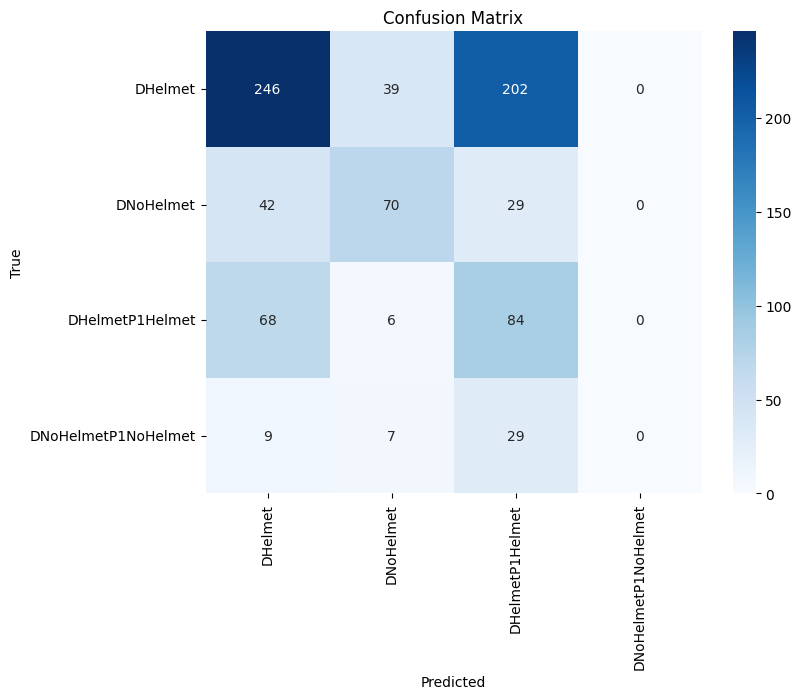

In [25]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluation ---
model.eval()
confidence_threshold = 0.4
all_true = []
all_pred = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            true_labels = targets[i]["labels"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            mask = scores >= confidence_threshold
            pred_labels = labels[mask]

            # Align lengths (truncate or pad)
            min_len = min(len(true_labels), len(pred_labels))
            if min_len > 0:
                all_true.extend(true_labels[:min_len])
                all_pred.extend(pred_labels[:min_len])


# --- Metrics ---
precision = precision_score(all_true, all_pred, average="weighted", zero_division=0)
recall = recall_score(all_true, all_pred, average="weighted", zero_division=0)
f1 = f1_score(all_true, all_pred, average="weighted", zero_division=0)

print("\nOverall Metrics for Test Data:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

label_names = ["DHelmet","DNoHelmet","DHelmetP1Helmet","DNoHelmetP1NoHelmet"]
# Detailed per-class report
print("\nClassification Report:")
print(classification_report(all_true, all_pred, target_names=list(train_dataset.class_to_label.keys())))

# --- Confusion Matrix ---
cm = confusion_matrix(all_true, all_pred, labels=[1,2,3,4])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Save the trained model

Save the state dictionary of the trained Faster R-CNN model to a file.


In [17]:
# 1. Define the path where the model state dictionary will be saved.
model_save_path = 'faster_rcnn_model.pth'

# 2. Save the model's state dictionary using torch.save().
torch.save(model.state_dict(), model_save_path)

# 3. Print a confirmation message indicating that the model has been saved successfully.
print(f"Model state dictionary saved successfully to {model_save_path}")

Model state dictionary saved successfully to faster_rcnn_model.pth


## Detect Object and Perform Counting


### Load the saved model


In [22]:
import cv2
import torch
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Tesla T4
Using device: cuda


In [23]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# class names
label_list= ["","DHelmet", "DNoHelmet", "DHelmetP1Helmet", "DNoHelmetP1NoHelmet"]

# 1. Define the number of classes for the model's head.
# Background + 4 custom classes
num_classes = 5

# 2. Instantiate the Faster R-CNN model with a ResNet50-FPN backbone.
# Make sure not to load the default pre-trained weights at this stage.
# Use weights=None to avoid loading default weights
model = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)

# 3. Define the path from where the model state dictionary will be loaded.
model_load_path = '/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/FasterRCNN/faster_rcnn_model.pth'

# 4. Load the saved state dictionary into the modified model.
model.load_state_dict(torch.load(model_load_path))

# 5. Move the loaded model to the appropriate device (CPU or GPU).
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 6. Print a confirmation message.
print(f"Model loaded successfully from {model_load_path} and moved to {device}.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


Model loaded successfully from /content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/FasterRCNN/faster_rcnn_model.pth and moved to cuda.


### Evaluate the model to detect objects in different scenario


In [34]:
import os
import torch
from PIL import Image
from torchvision.transforms import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the path to the test image
test_folder = '/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/dataset/augmented_samples'
annotation_file = "/content/drive/MyDrive/DegreeY3S1/BMDS2133_ImageProcessing/Assignment/dataset/preprocessed_data/fasterrcnn_annotations/fasterrcnn_test.json"

# Label map
label_to_class = {
    1: 'DHelmet',
    2: 'DNoHelmet',
    3: 'DHelmetP1Helmet',
    4: 'DNoHelmetP1NoHelmet'
}

# Load annotation JSON
with open(annotation_file, "r") as f:
    test_annotations = json.load(f)

confidence_threshold = 0.4

for file_name in os.listdir(test_folder):
    if not file_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    # Ground truth
    file_path = "/kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset/images/part_2/Mandalay_1_128/20.jpg"
    if file_path not in test_annotations:
        print(f"No ground truth for {file_path}, skipping.")
        continue

    gt_info = test_annotations[file_path]
    gt_boxes = torch.tensor([obj["bbox"] for obj in gt_info], dtype=torch.float32)
    gt_labels = torch.tensor([obj["label"] for obj in gt_info], dtype=torch.int64)

    # Load image
    test_file_path = os.path.join(test_folder, file_name)
    image_pil = Image.open(test_file_path).convert("RGB")
    image_tensor = F.to_tensor(image_pil).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)[0]

    mask = output["scores"] >= confidence_threshold
    pred_boxes = output["boxes"][mask].cpu()
    pred_labels = output["labels"][mask].cpu()
    pred_scores = output["scores"][mask].cpu()

    # Metrics
    all_true, all_pred = [], []
    min_len = min(len(gt_labels), len(pred_labels))
    if min_len > 0:
        all_true = gt_labels[:min_len].numpy()
        all_pred = pred_labels[:min_len].numpy()

        precision = precision_score(all_true, all_pred, average="weighted", zero_division=0)
        recall = recall_score(all_true, all_pred, average="weighted", zero_division=0)
        f1 = f1_score(all_true, all_pred, average="weighted", zero_division=0)
    else:
        precision = recall = f1 = 0.0

    # Print detections metrics
    print(f"\n{file_name} results:")
    print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        print(f" Det: {label_to_class.get(label.item(),'?')} "
              f"({score:.4f}), Box={box.tolist()}")

    # Helmet count
    helmet_wearers, no_helmet_wearers = 0, 0
    for label in pred_labels:
        if label.item() == 1:  # DHelmet
            helmet_wearers += 1
        elif label.item() == 2:  # DNoHelmet
            no_helmet_wearers += 1
        elif label.item() == 3:  # DHelmetP1Helmet
            helmet_wearers += 2
        elif label.item() == 4:  # DNoHelmetP1NoHelmet
            no_helmet_wearers += 2

    # Draw detections
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    text_color = (255, 255, 255)  # white text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 2

    if len(pred_boxes) > 0:
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x_min, y_min, x_max, y_max = [int(coord) for coord in box.tolist()]

            # Choose color: green for helmet, red for no helmet
            if label.item() in [2, 4]:
                box_color = (0, 0, 255)   # Red
            elif label.item() in [1, 3]:
                box_color = (0, 255, 0)   # Green
            else:
                box_color = (255, 255, 255)

            # Draw box
            cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), box_color, thickness)

            # Label + confidence
            class_name = label_to_class.get(label.item(), f"Unknown-{label.item()}")
            display_text = f"{class_name}: {score.item():.2f}"

            # Put text above the box
            text_size, _ = cv2.getTextSize(display_text, font, font_scale, thickness)
            text_x = x_min
            text_y = y_min - 10
            if text_y < text_size[1]:
                text_y = y_min + text_size[1]
            cv2.putText(image_bgr, display_text, (text_x, text_y),
                        font, font_scale, text_color, thickness)
    else:
        print("No detections found above threshold.")

    # Convert back to RGB for matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # ===================== DISPLAY =====================
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"{file_name}\n"
            f"Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}\n"
            f"Helmet={helmet_wearers}, NoHelmet={no_helmet_wearers}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.